## DML-Project
Object detection and classification of strawberry ripeness

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_image 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes 
from itertools import chain
from PIL import Image
from pathlib import Path
import os
import matplotlib.patches as patches
import cv2
import IPython
from sklearn.metrics import roc_curve

### Image folders

In [2]:
train_data = "./images/train"
val_data   = "./images/valid"
test_data  = "./images/test"

### Load datasets and apply transformations

Mosaic augmentation,
flips and rotations,
resize,
zoom in,
crop

In [3]:
class StrawberryData(Dataset):
    
    def __init__(self, root, transform=None, ripe_label=0, unripe_label=1):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
            
        self.root = Path(root)
        self.transform = transform
        self._ripe_label = ripe_label
        self._unripe_label = unripe_label
        
        self.image_paths = [os.path.join(root, 'images', img_name) for img_name in os.listdir(os.path.join(root, 'images'))]
        self.label_paths = [os.path.join(root, 'labels', label_name) for label_name in os.listdir(os.path.join(root, 'labels'))]
        
        self.image_paths.sort()
        self.label_paths.sort()
        
        self._samples = self._collect_samples()
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """

        strawberry_paths_and_labels = map(lambda path: (self.__getitem__(path)), self.image_paths)
        return strawberry_paths_and_labels
        
        #strawberry_paths_and_labels = map(lambda path: (path, self._dog_label), strawberry_paths)
        #return sorted(list(strawberry_paths_and_labels), key=lambda x: x[0].stem)
     
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")

    @staticmethod
    def _collect_labels_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.txt")
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        with open(label_path, 'r') as f:
            annotations = f.readlines()
            annotations = list(map(lambda x: x.replace("\n", "").split(" "), annotations))
        
        image = image_path
            
        if self.transform:
            image = Image.open(image_path)
            image = self.transform(image)

        return image, annotations

    def __len__(self):
        return len(self.image_paths)

In [4]:
transform = Compose([ToTensor()])

train_dataset       = StrawberryData(train_data, transform)
train_dataset_paths =  StrawberryData(train_data)
val_dataset   = StrawberryData(val_data, transform)
test_dataset  = StrawberryData(test_data, transform)

### Example image from the dataset

['1', '0.330078125', '0.326171875', '0.11328125', '0.126953125']


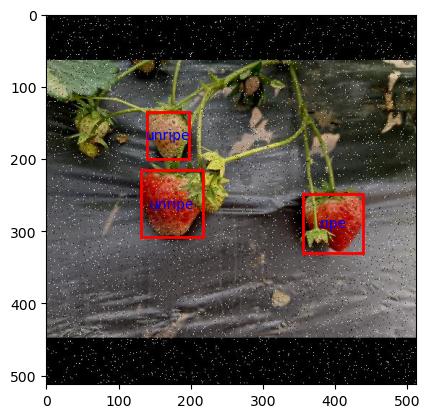

In [5]:
def display_image(axis, image_tensor, label):
    print(label[0])
    
    classification = {
        '0': 'ripe',
        '1': 'unripe'
    }

    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    axis.set_ylim(height, 0)
    for l in label:
            [lab, x1, y1, x2, y2] = l
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            rect = patches.Rectangle(((x1-(x2/2))*width, (y1-(y2/2))*height), x2*width, y2*height, linewidth=2, edgecolor='r', facecolor='none', label="asd")
            axis.add_patch(rect)
            text = axis.text(x1*width, y1*height, classification[lab], color="blue", ha="center", va="center")
    plt.show()

_, axis = plt.subplots()
image_tensor, label = train_dataset[0]
display_image(axis, image_tensor, label)



### Dataloaders

In [6]:
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader   = DataLoader(val_dataset, batch_size=val_dataset.__len__())
test_data_loader  = DataLoader(test_dataset, batch_size=test_dataset.__len__())

### Calculate redness percentage

In [245]:
def calculate_redness_percentage(image, bbox):
    # Crop the bounding box region
    
    image_tensor, labels_and_bboxes = image
    labels = [sublist[0] for sublist in labels_and_bboxes]
    redness_percentages = []
    upper_crop_ratio = 0.9 #smaller value more crop
    for box in bbox:
        x, y, w, h = box
        
        #crop each strawberry from the image
        cropped_image = image_tensor[:,int(y - h / 2):int(y + h / 2), int(x - w / 2):int(x + w / 2)]
        
        transform = torchvision.transforms.ToPILImage()
        img = transform(cropped_image)
        
        cropped_im_w, cropped_im_h = img.size
        cropped_im_x = cropped_im_w // 2
        cropped_im_y = cropped_im_h // 2
        
        #cropping out upper part (hull) of the image (The hull or calyx is the green leafy top of the strawberry)
        crop_height = int(cropped_im_h * upper_crop_ratio)
        
        #new bbox coordinates
        x_new = cropped_im_x
        y_new = cropped_im_h - int(crop_height // 2)
        w_new = cropped_im_w
        h_new = crop_height
        
        #crop out the hull of the strawberry
        final_cropped_image = cropped_image[:, int(y_new - h_new / 2):int(y_new + h_new / 2), int(x_new - w_new / 2):int(x_new + w_new / 2)]
        np_cropped_image = final_cropped_image.numpy()
        
        transposed_cropped_image = np.transpose(final_cropped_image, (1, 2, 0))
        np_transposed_cropped_image = transposed_cropped_image.numpy()
        
        transform = torchvision.transforms.ToPILImage()
        img = transform(final_cropped_image)
        plt.imshow(img)
        plt.show()

        hsv = cv2.cvtColor(np_transposed_cropped_image, cv2.COLOR_RGB2HSV)

        lower1 = np.array([0,0,0])
        upper1 = np.array([10,255,255])

        lower2 = np.array([160, 0, 0])
        upper2 = np.array([179, 255, 255])

        lower_mask = cv2.inRange(hsv, lower1, upper1)
        upper_mask = cv2.inRange(hsv, lower2, upper2)
        
        full_mask = cv2.bitwise_or(lower_mask, upper_mask)
        
        plt.imshow(full_mask)
        plt.show()
        # Display the mask

        red_pixel_count = np.count_nonzero(full_mask)
        total_pixel_count = w * h

        redness_percentage = (red_pixel_count / total_pixel_count)
        formatted_redness_percentage = "{:.4f}".format(redness_percentage)
        #print("redness percentage for this specific strawberry: ", formatted_redness_percentage)
        redness_percentages.append(formatted_redness_percentage)

    return redness_percentages, labels

def calculate_hsv_yolo(image, truths):
    # Crop the bounding box region
    
    image_tensor, labels_and_bboxes = image
    labels = [sublist[4] for sublist in labels_and_bboxes]
    hsv = []
    upper_crop_ratio = 0.9 #smaller value more crop
    for index,box in enumerate(labels_and_bboxes):
        [x1, y1, x2, y2, _] = box
        
        #crop each strawberry from the image
        cropped_image = image_tensor[:,int(y1):int(y2), int(x1):int(x2)]
        
        transform = torchvision.transforms.ToPILImage()
        img = transform(cropped_image)
        
        cropped_im_w, cropped_im_h = img.size
        cropped_im_x = cropped_im_w // 2
        cropped_im_y = cropped_im_h // 2
        
        #cropping out upper part (hull) of the image (The hull or calyx is the green leafy top of the strawberry)
        crop_height = int(cropped_im_h * upper_crop_ratio)
        
        #new bbox coordinates
        x_new = cropped_im_x
        y_new = cropped_im_h - int(crop_height // 2)
        w_new = cropped_im_w
        h_new = crop_height
        
        #crop out the hull of the strawberry
        final_cropped_image = cropped_image[:, int(y_new - h_new / 2):int(y_new + h_new / 2), int(x_new - w_new / 2):int(x_new + w_new / 2)]
        np_cropped_image = final_cropped_image.numpy()
        
        transposed_cropped_image = np.transpose(final_cropped_image, (1, 2, 0))
        np_transposed_cropped_image = transposed_cropped_image.numpy()
        
        transform = torchvision.transforms.ToPILImage()
        img = transform(final_cropped_image)
        plt.imshow(img)
        plt.show()

        img_hsv = cv2.cvtColor(np_transposed_cropped_image, cv2.COLOR_RGB2HSV)
        average_hsv = cv2.mean(img_hsv)[:3]
        hsv.append(average_hsv)
    return hsv, truths

def calculate_hsv(image, bbox):
    # Crop the bounding box region
    
    image_tensor, labels_and_bboxes = image
    labels = [sublist[0] for sublist in labels_and_bboxes]
    hsv = []
    upper_crop_ratio = 0.9 #smaller value more crop
    for box in bbox:
        x, y, w, h = box
        
        #crop each strawberry from the image
        cropped_image = image_tensor[:,int(y - h / 2):int(y + h / 2), int(x - w / 2):int(x + w / 2)]
        
        transform = torchvision.transforms.ToPILImage()
        img = transform(cropped_image)
        
        cropped_im_w, cropped_im_h = img.size
        cropped_im_x = cropped_im_w // 2
        cropped_im_y = cropped_im_h // 2
        
        #cropping out upper part (hull) of the image (The hull or calyx is the green leafy top of the strawberry)
        crop_height = int(cropped_im_h * upper_crop_ratio)
        
        #new bbox coordinates
        x_new = cropped_im_x
        y_new = cropped_im_h - int(crop_height // 2)
        w_new = cropped_im_w
        h_new = crop_height
        
        #crop out the hull of the strawberry
        final_cropped_image = cropped_image[:, int(y_new - h_new / 2):int(y_new + h_new / 2), int(x_new - w_new / 2):int(x_new + w_new / 2)]
        np_cropped_image = final_cropped_image.numpy()
        
        transposed_cropped_image = np.transpose(final_cropped_image, (1, 2, 0))
        np_transposed_cropped_image = transposed_cropped_image.numpy()
        
        transform = torchvision.transforms.ToPILImage()
        img = transform(final_cropped_image)
        plt.imshow(img)
        plt.show()

        img_hsv = cv2.cvtColor(np_transposed_cropped_image, cv2.COLOR_RGB2HSV)
        
        average_hsv = cv2.mean(img_hsv)[:3]
        
        hsv.append(average_hsv)

    return hsv, labels

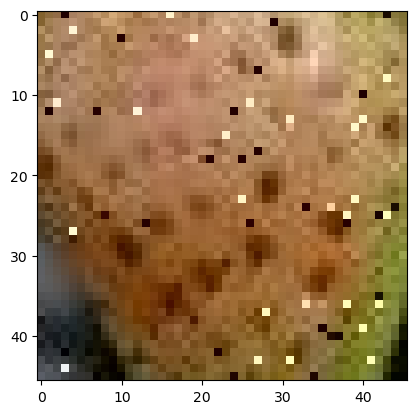

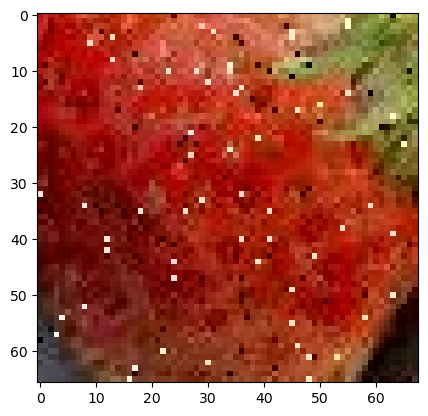

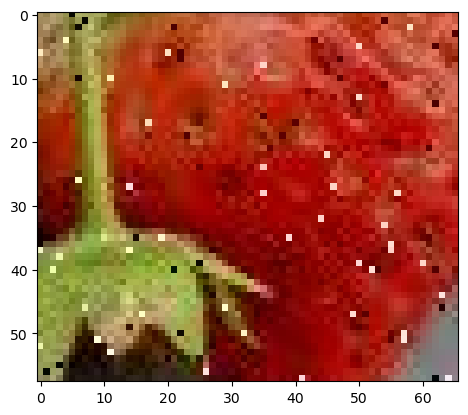

hsv example:  [(37.323599144393874, 0.5730198317027821, 0.5820416038211554), (21.778280466323494, 0.8153006267661657, 0.5891414298962323), (33.27646062575289, 0.7992173412592368, 0.6177331290164985)]


In [8]:
def get_bbox(label): #label is an array of labels for each image
    height = 512
    width = 512
    ratio = 0.8 #smaller value more zoom
    bbox = [] # bbox is an array of bounding boxes for each image with ratio applied
    for l in label:
            [lab, x1, y1, x2, y2] = l
            x1, y1, x2, y2 = float(x1), float(y1), float(x2), float(y2)
            rect = patches.Rectangle(((x1-(x2/2))*width, (y1-(y2/2))*height), x2*width, y2*height, linewidth=2, edgecolor='r', facecolor='none', label="asd")
            x_center, y_center = rect.get_center()
            #get original bbox dimensions
            w = rect.get_width()
            h = rect.get_height()
            #zooming in the bounding box by reducing width and height
            new_w = w*ratio
            new_h = h*ratio
            bb = [int(x_center), int(y_center), int(new_w), int(new_h)]
            bbox = bbox + [bb]
    return bbox

#def reduce_bbox(bbox):
#    ratio = 0.75
#    new_bboxes = []
#    for box in bbox:
#        x, y, w, h = box
#        new_width = w*ratio
#        new_height = h*height
#        new_bbox = [x, y, new_width, new_height]
#        new_bboxes = new_bboxes + [new_bbox]
#    return new_bboxes
        

# Define bounding box coordinates (x, y, width, height)
bbox = get_bbox(label) # array of bounding boxes

image_width = 512
image_height = 512

def unnormalize_bbox(normalized_bbox, image_width, image_height):
    unnormalized_bbox = []
    for bbox in normalized_bbox:
        x, y, w, h = bbox
        x_pixel = int(x * image_width)
        y_pixel = int(y * image_height)
        width_pixel = int(w * image_width)
        height_pixel = int(h * image_height)
        unnormalized_bbox = unnormalized_bbox + [[x_pixel, y_pixel, width_pixel, height_pixel]]
    return unnormalized_bbox #array of unnormalized bboxes

#print(bbox)


# Calculate the redness percentage
#redness_percentage, labels = calculate_redness_percentage(train_dataset[6], bbox) #image tensor and array of unnormalized_bboxes
#print("Redness Percentage: ", redness_percentage)
#print("Labels: ", labels)

hsvs, hsvs_labels = calculate_hsv(train_dataset[0], bbox) #image tensor and array of unnormalized_bboxes
print("hsv example: ", hsvs)
#print("Labels: ", hsvs_labels[0])

### YOLOv5
#### Install

In [9]:
#!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

#### Run the training script

To train the YOLOv5 with our own images we need can create our own data config file that specifies the location where our images and labels are. And what classes we want it to find. This can be done by simply creating a yaml file that specifies all the locations and labels.

Firstly, we download the yolov5 repo and install the dependencies, this should be done in the same folder as `dml-project`.

Run the following from the terminal:
```
git clone https://github.com/ultralytics/yolov5  # clone
cd yolov5
pip install -r requirements.txt  # install
```
We can then use our `strawberryripness.yaml` that looks like:

```
path: ../dml-project # dataset root dir
train: images/train # train images (relative to 'path')
val: images/valid # val images (relative to 'path')
test: images/test # test images

names:
    0: ripe
    1: unripe
```


Then we can perform training by running:

In [10]:
#!python ../yolov5/train.py --img 512 --batch-size 32 --epochs 150 --data strawberryripeness.yaml --weights yolov5s.pt

What this does is basically running the yolov5 training script for 150 epochs with the pretrained weights and our defined classes and labels. From this we get new weights that are saved in the `strawberries.pt` file. 

Here is how the result came back after training with the strawberries!

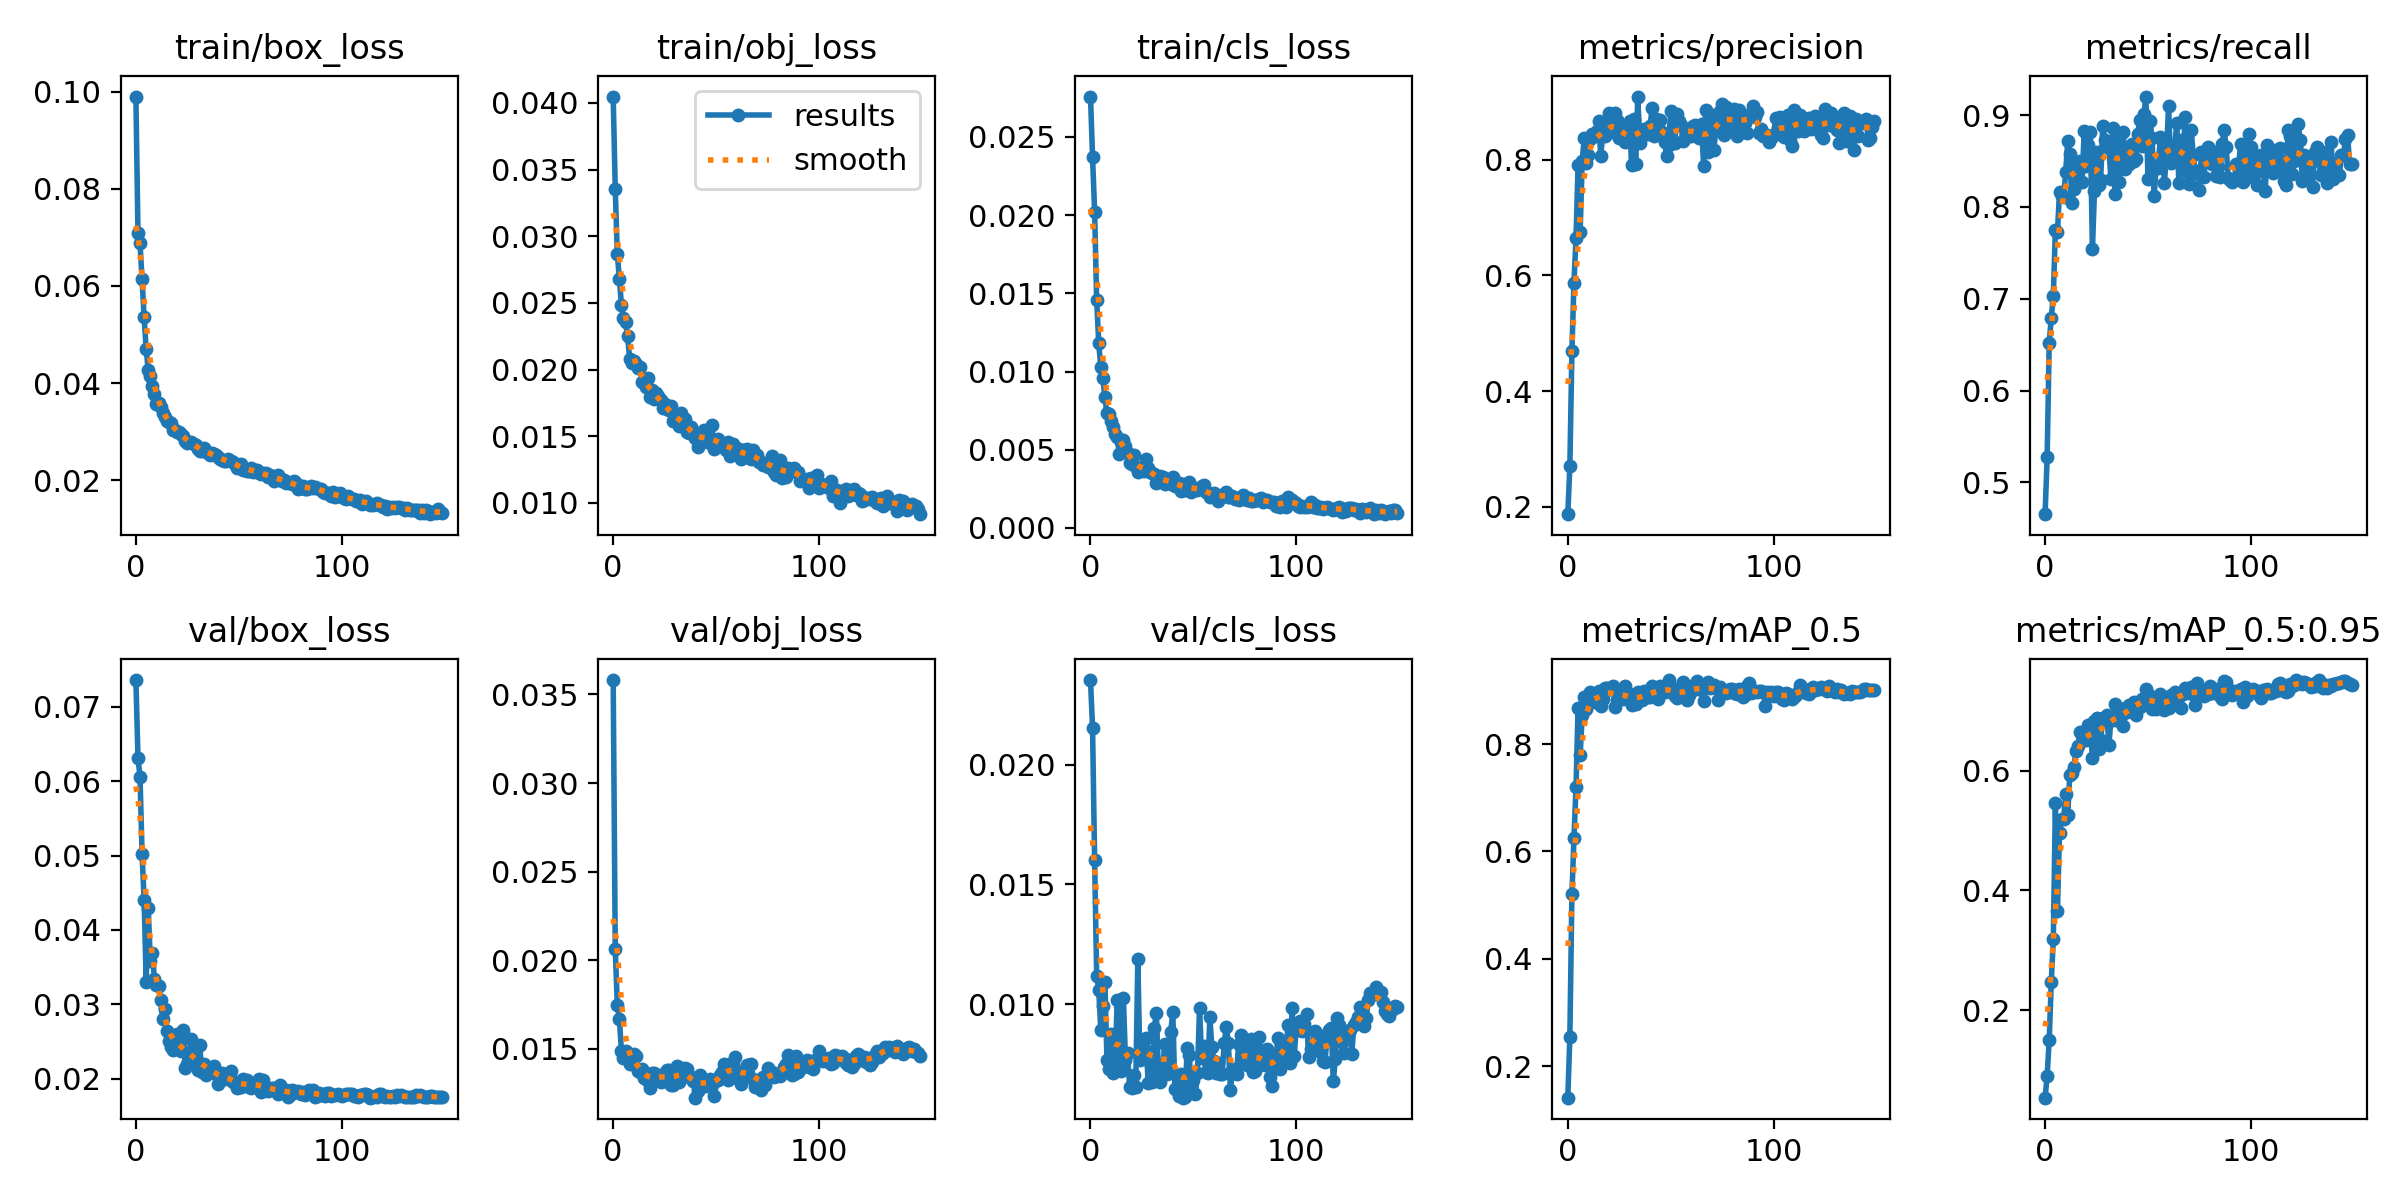

In [11]:
IPython.display.Image('./results.png')

#### Now we can validate the model

This is done in a similar fashion to the training, we run:

In [12]:
#!python ../yolov5/val.py --weights strawberries.pt --data strawberryripeness.yaml --img 512

And this is how some of the predictions done by the validation looked

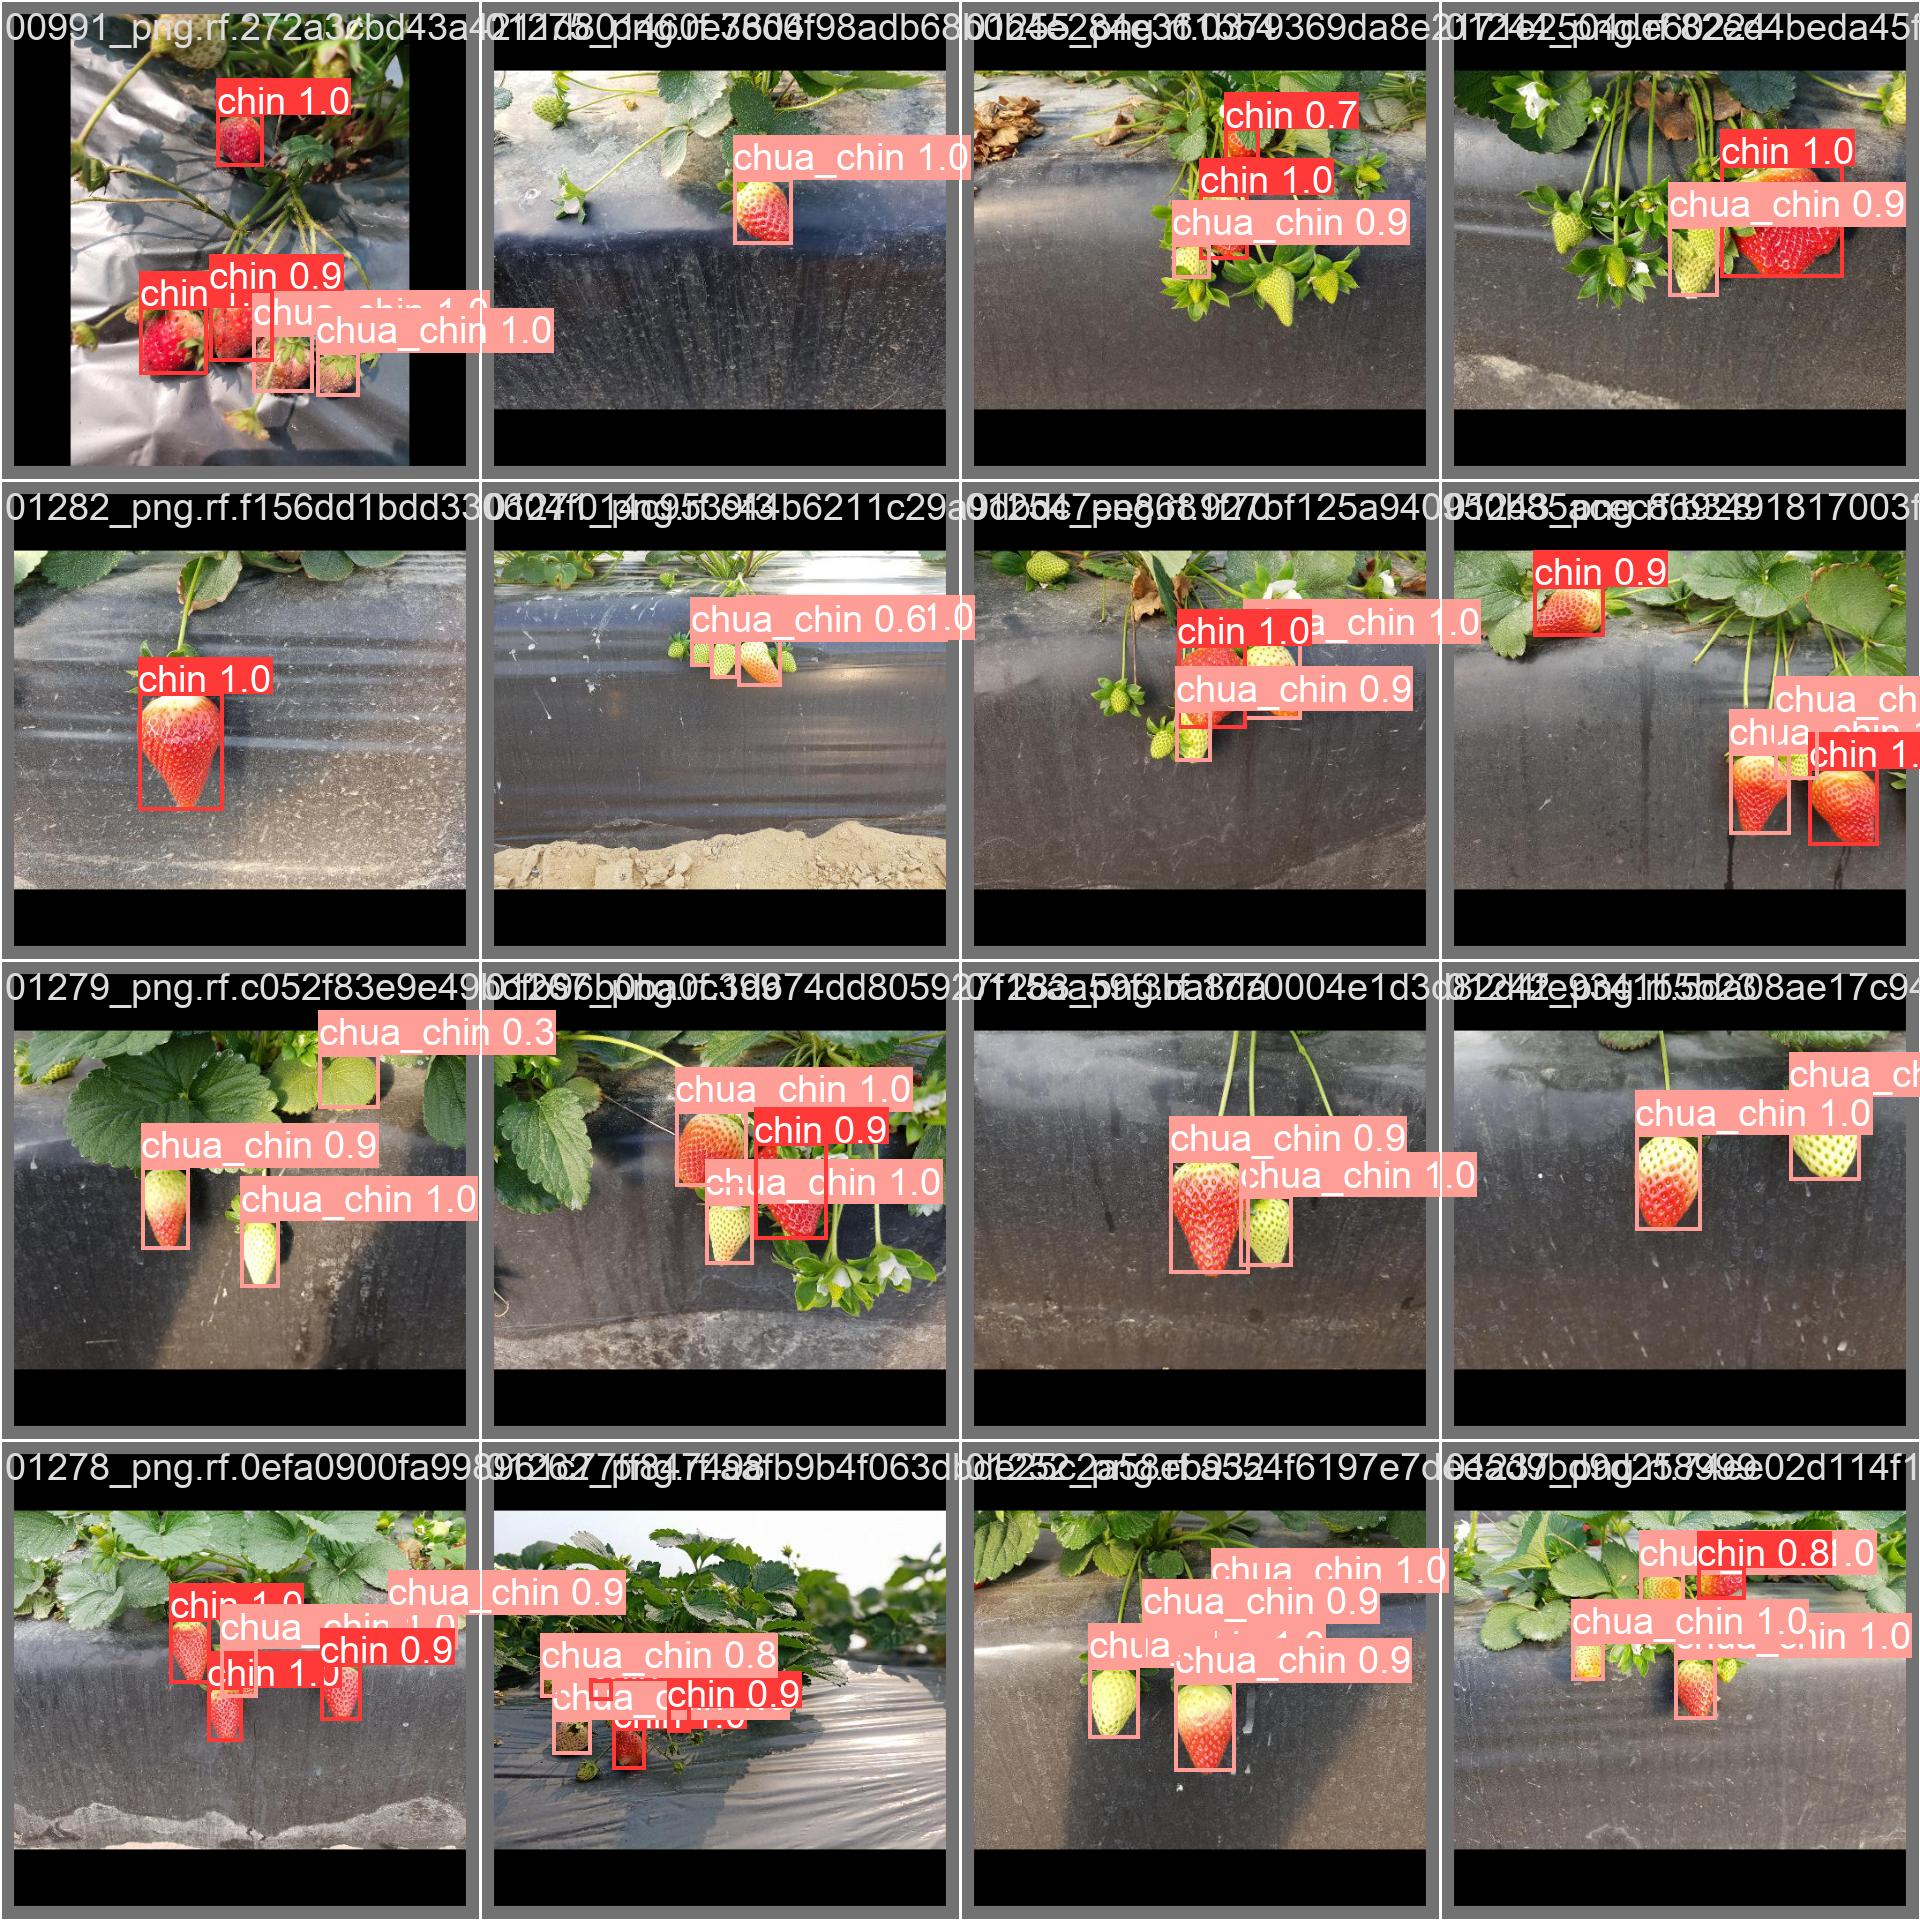

In [13]:
IPython.display.Image('val_batch0_pred.jpg')


#### Import the model

Now we can import the model using pytorch and the trained weights

We can then look at specific examples of it detecting strawberries

In [151]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='strawberries.pt')

Using cache found in /Users/lucaskarlsson/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 ðŸš€ 2023-10-10 Python-3.9.16 torch-1.11.0.post2 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


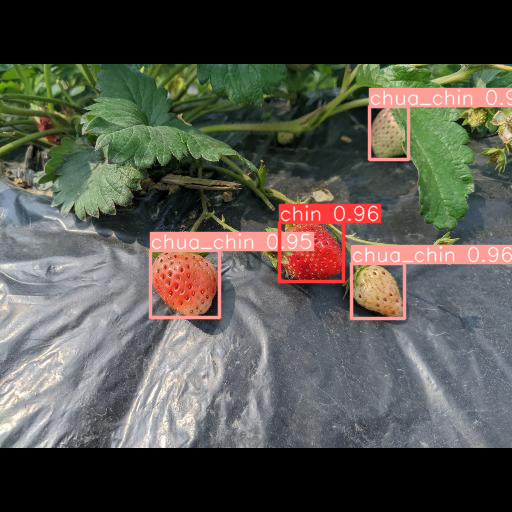

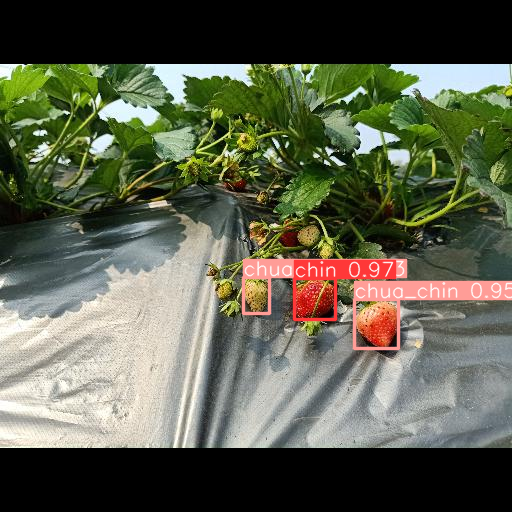

In [152]:
im = './images/test/images/00481_png.rf.147a45e27afacce08a40b158204a3231.jpg'
results = model(im)
results.show()

im2= 'images/test/images/00224_png.rf.ee06924eb7629c410a2323198d4d18d4.jpg'
results = model(im2)
results.show()

#### Training the redness regression model

Now we can use `calculate_redness_precentage` and map it over the entire dataset to get the data we can use on our regression model

In [16]:
#Function used to obtain the redness percentage + labels of each strawberry. Input: strawberry dataset
def from_StrawberryDataset_to_HSVDataset(dataset):
    
    redness  = []
    act_lab = []
    
    for (image_tensor, label) in dataset:
        bbox = get_bbox(label)
        res, lab = calculate_hsv((image_tensor, label), bbox) #changed
        redness.extend(res)
        act_lab.extend(lab)
        
    float_redness = [[float(x), float(y), float(z)] for x,y,z in redness]
    int_lab = [[int(element)] for element in act_lab]
    
    return float_redness, int_lab

def from_StrawberryDataset_to_RednessDataset(dataset):
    
    redness  = []
    act_lab = []
    
    for (image_tensor, label) in dataset:
        bbox = get_bbox(label)
        res, lab = calculate_redness_percentage((image_tensor, label), bbox) #changed
        redness.extend(res)
        act_lab.extend(lab)
        
    float_redness = [[float(x)] for x in redness]
    int_lab = [[int(element)] for element in act_lab]
    
    return float_redness, int_lab

#obtain variables to create new datasets
train_redness, train_labels = from_StrawberryDataset_to_RednessDataset(train_dataset)
val_redness, val_labels = from_StrawberryDataset_to_RednessDataset(val_dataset)
test_redness, test_labels = from_StrawberryDataset_to_RednessDataset(test_dataset)

train_hsv, train_hsv_labels = from_StrawberryDataset_to_HSVDataset(train_dataset)
val_hsv, val_hsv_labels = from_StrawberryDataset_to_HSVDataset(val_dataset)
test_hsv, test_hsv_labels = from_StrawberryDataset_to_HSVDataset(test_dataset)


# Redness Dataloaders

In [17]:
from torch.utils.data import TensorDataset

torch_train_redness = torch.tensor(train_redness, dtype=torch.float32)
torch_train_labels = torch.tensor(train_labels, dtype=torch.int64)

torch_val_redness = torch.tensor(val_redness, dtype=torch.float32)
torch_val_labels = torch.tensor(val_labels, dtype=torch.int64)

torch_test_redness = torch.tensor(test_redness, dtype=torch.float32)
torch_test_labels = torch.tensor(test_labels, dtype=torch.int64)

train_redness_dataset = TensorDataset(torch_val_redness, torch_val_labels)
train_redness_data_loader = DataLoader(train_redness_dataset, batch_size=32, shuffle=True)

val_redness_dataset = TensorDataset(torch_train_redness, torch_train_labels)
val_redness_data_loader = DataLoader(val_redness_dataset, batch_size=len(val_redness), shuffle=True)

test_redness_dataset = TensorDataset(torch_test_redness, torch_test_labels)
test_redness_data_loader = DataLoader(test_redness_dataset, batch_size=len(test_redness), shuffle=True)

# HSV Dataloaders

In [18]:
torch_train_hsv = torch.tensor(train_hsv, dtype=torch.float32)
torch_train_hsv_labels = torch.tensor(train_hsv_labels, dtype=torch.int64)

torch_val_hsv = torch.tensor(val_hsv, dtype=torch.float32)
torch_val_hsv_labels = torch.tensor(val_hsv_labels, dtype=torch.int64)

torch_test_hsv = torch.tensor(test_hsv, dtype=torch.float32)
torch_test_hsv_labels = torch.tensor(test_hsv_labels, dtype=torch.int64)

train_hsv_dataset = TensorDataset(torch_val_hsv, torch_val_hsv_labels)
train_hsv_data_loader = DataLoader(train_hsv_dataset, batch_size=16, shuffle=True)

val_hsv_dataset = TensorDataset(torch_train_hsv, torch_train_hsv_labels)
val_hsv_data_loader = DataLoader(val_hsv_dataset, batch_size=len(val_hsv), shuffle=True)

test_hsv_dataset = TensorDataset(torch_test_hsv, torch_test_hsv_labels)
test_hsv_data_loader = DataLoader(test_hsv_dataset, batch_size=len(test_hsv), shuffle=True)

# Necessary functions to train and validate the logistic regressor

In [19]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    return t

def output_to_label(z, t): #z = [0.5345, 0.5272, 0.5397, 0.5290, 0.5285, 0.5266, 0.5330, 0.5297]
    """Map network output z to a hard label {0, 1}
    
    Args:
        z (Tensor): Probabilities for each sample in a batch.
    Returns:
        c (Tensor): Hard label {0, 1} for each sample in a batch
    """
    return (z > t).long()

def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())
        t = 0
        with torch.no_grad():
            fpr, tpr, threshold = roc_curve(labels, z)
            t = find_best_threshold(threshold, fpr, tpr)
            
        hard_preds = output_to_label(z, t)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)
            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            
            fpr, tpr, threshold = roc_curve(labels, z)
            t = find_best_threshold(threshold, fpr, tpr)
            
            hard_preds = output_to_label(z, t)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

# Build Logistic Regression Network

In [213]:
import torch.nn.functional as F
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 32)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(32, 32)
        self.relu2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(32, 1)
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        return x
    
    @staticmethod
    def sigmoid_torch(x):
        k = 5  # Sigmoid gradient
        global x0  # Access the global variable x0
        output = 1 - 1 / (1 + torch.exp(-k * (x - x0)))  # Apply the vertical mirror
        return output

from torch import optim

epochs = 1 
#Dimensions for logistic regression. 1 Input (redness percentage), 1 output (label)


# Training (redness percentage)

In [240]:
regressor = LogisticRegression(1, 1)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr = 0.01)

regressor, train_losses, train_accs, val_losses, val_accs = training_loop(regressor, optimizer, loss_fn, train_redness_data_loader, val_redness_data_loader, 200,None)

Starting training
Epoch 1/200: Train loss: 0.633, Train acc.: 0.744, Val. loss: 0.598, Val. acc.: 0.847
Epoch 2/200: Train loss: 0.557, Train acc.: 0.806, Val. loss: 0.515, Val. acc.: 0.849
Epoch 3/200: Train loss: 0.502, Train acc.: 0.804, Val. loss: 0.425, Val. acc.: 0.847
Epoch 4/200: Train loss: 0.435, Train acc.: 0.796, Val. loss: 0.373, Val. acc.: 0.848
Epoch 5/200: Train loss: 0.422, Train acc.: 0.799, Val. loss: 0.358, Val. acc.: 0.845
Epoch 6/200: Train loss: 0.410, Train acc.: 0.810, Val. loss: 0.358, Val. acc.: 0.844
Epoch 7/200: Train loss: 0.413, Train acc.: 0.819, Val. loss: 0.348, Val. acc.: 0.848
Epoch 8/200: Train loss: 0.396, Train acc.: 0.817, Val. loss: 0.356, Val. acc.: 0.848
Epoch 9/200: Train loss: 0.391, Train acc.: 0.837, Val. loss: 0.359, Val. acc.: 0.842
Epoch 10/200: Train loss: 0.404, Train acc.: 0.799, Val. loss: 0.343, Val. acc.: 0.852
Epoch 11/200: Train loss: 0.393, Train acc.: 0.810, Val. loss: 0.348, Val. acc.: 0.844
Epoch 12/200: Train loss: 0.375, T

Epoch 100/200: Train loss: 0.329, Train acc.: 0.813, Val. loss: 0.319, Val. acc.: 0.841
Epoch 101/200: Train loss: 0.339, Train acc.: 0.834, Val. loss: 0.321, Val. acc.: 0.839
Epoch 102/200: Train loss: 0.326, Train acc.: 0.820, Val. loss: 0.345, Val. acc.: 0.840
Epoch 103/200: Train loss: 0.335, Train acc.: 0.819, Val. loss: 0.326, Val. acc.: 0.845
Epoch 104/200: Train loss: 0.324, Train acc.: 0.820, Val. loss: 0.336, Val. acc.: 0.841
Epoch 105/200: Train loss: 0.346, Train acc.: 0.817, Val. loss: 0.327, Val. acc.: 0.841
Epoch 106/200: Train loss: 0.324, Train acc.: 0.816, Val. loss: 0.333, Val. acc.: 0.839
Epoch 107/200: Train loss: 0.323, Train acc.: 0.831, Val. loss: 0.331, Val. acc.: 0.835
Epoch 108/200: Train loss: 0.326, Train acc.: 0.807, Val. loss: 0.324, Val. acc.: 0.840
Epoch 109/200: Train loss: 0.342, Train acc.: 0.833, Val. loss: 0.327, Val. acc.: 0.842
Epoch 110/200: Train loss: 0.344, Train acc.: 0.804, Val. loss: 0.332, Val. acc.: 0.837
Epoch 111/200: Train loss: 0.337

Epoch 200/200: Train loss: 0.326, Train acc.: 0.805, Val. loss: 0.329, Val. acc.: 0.841


## Evaluating on the test data (redness percentage)

In [241]:
test_loss_cum = 0
test_acc_cum = 0
regressor.eval()
trained_threshold = 0

with torch.no_grad():
    for batch_index, (x, y) in enumerate(test_redness_data_loader, 1):
        device = torch.device("cuda" if torch.cuda.is_available() 
                              else "cpu")
        inputs, labels = x.to(device), y.to(device)
        z = regressor.forward(inputs)
        batch_loss = loss_fn(z, labels.float())
        test_loss_cum += batch_loss.item()
        
        fpr, tpr, threshold = roc_curve(labels, z)
        trained_threshold = find_best_threshold(threshold, fpr, tpr)

        hard_preds = output_to_label(z, trained_threshold)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        test_acc_cum += acc_batch_avg
        
print("loss:", test_loss_cum/len(test_redness_data_loader), "acc:",test_acc_cum/len(test_redness_data_loader))

loss: 0.36443594098091125 acc: 0.8122065663337708


## Training (HSV)

In [217]:
regressor_hsv = LogisticRegression(3, 1)

loss_fn_hsv = torch.nn.BCELoss()
optimizer_hsv = torch.optim.Adam(regressor.parameters(), lr = 0.01)

regressor_hsv, train_losses_hsv, train_accs_hsv, val_losses_hsv, val_accs_hsv = training_loop(regressor_hsv, optimizer_hsv, loss_fn_hsv, train_hsv_data_loader, val_hsv_data_loader, 200,None)

Starting training
Epoch 1/200: Train loss: 1.506, Train acc.: 0.853, Val. loss: 1.472, Val. acc.: 0.800
Epoch 2/200: Train loss: 1.504, Train acc.: 0.809, Val. loss: 1.474, Val. acc.: 0.811
Epoch 3/200: Train loss: 1.505, Train acc.: 0.838, Val. loss: 1.472, Val. acc.: 0.806
Epoch 4/200: Train loss: 1.507, Train acc.: 0.838, Val. loss: 1.473, Val. acc.: 0.807
Epoch 5/200: Train loss: 1.508, Train acc.: 0.848, Val. loss: 1.483, Val. acc.: 0.810
Epoch 6/200: Train loss: 1.508, Train acc.: 0.833, Val. loss: 1.480, Val. acc.: 0.809
Epoch 7/200: Train loss: 1.506, Train acc.: 0.848, Val. loss: 1.488, Val. acc.: 0.804
Epoch 8/200: Train loss: 1.506, Train acc.: 0.812, Val. loss: 1.470, Val. acc.: 0.806
Epoch 9/200: Train loss: 1.508, Train acc.: 0.847, Val. loss: 1.467, Val. acc.: 0.810
Epoch 10/200: Train loss: 1.505, Train acc.: 0.791, Val. loss: 1.476, Val. acc.: 0.811
Epoch 11/200: Train loss: 1.506, Train acc.: 0.854, Val. loss: 1.473, Val. acc.: 0.804
Epoch 12/200: Train loss: 1.505, T

Epoch 96/200: Train loss: 1.504, Train acc.: 0.782, Val. loss: 1.475, Val. acc.: 0.815
Epoch 97/200: Train loss: 1.506, Train acc.: 0.838, Val. loss: 1.469, Val. acc.: 0.806
Epoch 98/200: Train loss: 1.505, Train acc.: 0.838, Val. loss: 1.472, Val. acc.: 0.812
Epoch 99/200: Train loss: 1.507, Train acc.: 0.853, Val. loss: 1.471, Val. acc.: 0.803
Epoch 100/200: Train loss: 1.504, Train acc.: 0.791, Val. loss: 1.474, Val. acc.: 0.812
Epoch 101/200: Train loss: 1.509, Train acc.: 0.806, Val. loss: 1.477, Val. acc.: 0.812
Epoch 102/200: Train loss: 1.506, Train acc.: 0.841, Val. loss: 1.473, Val. acc.: 0.807
Epoch 103/200: Train loss: 1.503, Train acc.: 0.835, Val. loss: 1.474, Val. acc.: 0.799
Epoch 104/200: Train loss: 1.507, Train acc.: 0.845, Val. loss: 1.474, Val. acc.: 0.812
Epoch 105/200: Train loss: 1.507, Train acc.: 0.850, Val. loss: 1.474, Val. acc.: 0.819
Epoch 106/200: Train loss: 1.506, Train acc.: 0.849, Val. loss: 1.463, Val. acc.: 0.813
Epoch 107/200: Train loss: 1.507, Tr

Epoch 195/200: Train loss: 1.507, Train acc.: 0.844, Val. loss: 1.472, Val. acc.: 0.805
Epoch 196/200: Train loss: 1.509, Train acc.: 0.859, Val. loss: 1.473, Val. acc.: 0.802
Epoch 197/200: Train loss: 1.510, Train acc.: 0.846, Val. loss: 1.472, Val. acc.: 0.808
Epoch 198/200: Train loss: 1.505, Train acc.: 0.803, Val. loss: 1.467, Val. acc.: 0.805
Epoch 199/200: Train loss: 1.504, Train acc.: 0.827, Val. loss: 1.479, Val. acc.: 0.812
Epoch 200/200: Train loss: 1.504, Train acc.: 0.838, Val. loss: 1.475, Val. acc.: 0.813


## Evaluating on the test data (HSV)

In [218]:
test_loss_cum = 0
test_acc_cum = 0
regressor_hsv.eval()
with torch.no_grad():
    for batch_index, (x, y) in enumerate(test_hsv_data_loader, 1):
        device = torch.device("cuda" if torch.cuda.is_available() 
                              else "cpu")
        inputs, labels = x.to(device), y.to(device)
        z = regressor_hsv.forward(inputs)
        batch_loss = loss_fn_hsv(z, labels.float())
        test_loss_cum += batch_loss.item()
        
        fpr, tpr, threshold = roc_curve(labels, z)
        t = find_best_threshold(threshold, fpr, tpr)

        hard_preds = output_to_label(z, t)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        test_acc_cum += acc_batch_avg
        
print("loss:", test_loss_cum/len(test_hsv_data_loader), "acc:",test_acc_cum/len(test_hsv_data_loader))

loss: 1.4199767112731934 acc: 0.8450704216957092


## Passing yolov5 to regression model

In [248]:
def get_bbox(label): #label is an array of labels for each image
    height = 512
    width = 512
   
    [lab, cx1, cy1, w, h] = label
    x1 = (cx1-(w/2))*height
    y1 = (cy1-(h/2))*width
    x2 = (cx1+(w/2))*height
    y2 = (cy1+(h/2))*height

    bbox = [x1,y1,x2,y2,lab]
    return bbox


def get_annot(label_path):
    with open(label_path, 'r') as f:
        annotations = f.readlines()
        annotations = list(map(lambda x: get_bbox(list(map(float, x.replace("\n", "").split(" ")))), annotations))
        return annotations
    
def iou(b1, b2):
    [x1,y1,x2,y2,lab1] = b1
    [x3,y3,x4,y4,lab2] = b2
    x_insec1 = max(x1,x3)
    y_insec1 = max(y1,y3)
    x_insec2 = min(x2,x4)
    y_insec2 = min(y2,y4)
    area1 = (x2-x1) * (y2-y1)
    area2 = (x4-x3) * (y4-y3)
    if x_insec1 < x_insec2 and y_insec1 < y_insec2:
        intersection = (x_insec2 - x_insec1) * (y_insec2 - y_insec1)
    else:
        intersection = 0
    union = area1 + area2 - intersection
    iou = intersection / union
    return iou
    
transform_yolo = Compose([ToTensor()])
root = Path('./images/test')
image_paths = [os.path.join(root, 'images', img_name) for img_name in os.listdir(os.path.join(root, 'images'))]
label_paths = [os.path.join(root, 'labels', label_name) for label_name in os.listdir(os.path.join(root, 'labels'))]
image_paths.sort()
label_paths.sort()
label_paths = list(map(get_annot, label_paths))

#results = model([image_paths[0], image_paths[1], image_paths[2], image_paths[3]])
results = model(image_paths)

yolo_x = []
yolo_y = []

for index,img in enumerate(results.xyxy):
    ground_truths = []
    strawberries = []
    for strawberry in img:
        strawberry = [strawberry[0], strawberry[1], strawberry[2], strawberry[3], strawberry[5]]
        image = Image.open(image_paths[index])
        t_image = transform_yolo(image)
        
        iou_list = []
        for label in label_paths[index]:
            iou_list.append(iou(label, strawberry))
        
        if (sum(iou_list) == 0): ##no bounding box
            continue
        
        lab_index = iou_list.index(max(iou_list))
        ground_truth = int(label_paths[index][lab_index][4])
        ground_truths.append(ground_truth)
        strawberries.append(strawberry)
        #print("label:", ground_truth)
        #print("pred_label:", int(strawberry[4]))
        #print("--------")
    
    rednesses, label = calculate_hsv_yolo((t_image, strawberries), ground_truths)
    yolo_x.extend(rednesses)
    yolo_y.extend(label)
    
yolo_x = [[float(x), float(y), float(z)] for x,y,z in yolo_x]
yolo_y = [[int(element)] for element in yolo_y]

yolo_torch_test_redness = torch.tensor(yolo_x, dtype=torch.float32)
yolo_torch_test_labels = torch.tensor(yolo_y, dtype=torch.int64)
yolo_test_redness_dataset = TensorDataset(yolo_torch_test_redness, yolo_torch_test_labels)
yolo_test_redness_data_loader = DataLoader(yolo_test_redness_dataset, batch_size=len(yolo_y), shuffle=True)

In [255]:
val_loss_cum = 0
val_acc_cum = 0

with torch.no_grad():
    for batch_index, (x, y) in enumerate(yolo_test_redness_data_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        z = regressor_hsv.forward(inputs)
        batch_loss = loss_fn(z, labels.float())
        val_loss_cum += batch_loss.item()

        fpr, tpr, threshold = roc_curve(labels, z)
        t = find_best_threshold(threshold, fpr, tpr)
        
        hard_preds = output_to_label(z, t)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        val_acc_cum += acc_batch_avg
print(val_loss_cum/len(yolo_test_redness_data_loader), val_acc_cum/len(yolo_test_redness_data_loader))

1.5584417581558228 0.8640776872634888
